In [6]:
import h5netcdf
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv
import os
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import cartopy.crs as ccrs
import cartopy.util as cutil
import xarray as xr
from matplotlib import animation
from scipy.interpolate import interp2d
from scipy.integrate import quad
from matplotlib import cm
import string
import matplotlib.colors as mcolors
import matplotlib.backends.backend_pdf
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size'   : 9})
rc('text', usetex=True)
import matplotlib.backends.backend_pdf

Get the data for the streamfunction


In [10]:
time = [0]
rundir = '../../actual_runs/runs_4_degree_last/'

yearsdone = []
ranfory = []
BSF = []
MOC = []
SSS = []
area_u = []
area_v = []
TEMP = []
u = []
v = []
xt = []
yt = []
zt = []
dzt = []
dyt = []
dxt = []
dyu = []

for year in time:
    if os.path.exists(rundir + 'Run%i/run_%ima.current_run' % (year,year)):
        with open(rundir + 'Run%i/run_%ima.current_run' % (year,year)) as f:
            ranfor = int(f.readline())
        ranfory.append(ranfor)
        yearsdone.append(year)
        with xr.open_dataset(rundir + 'Run%i/run_%ima.%04d.averages.nc'% (year,year,ranfor-1)) as ds:
            BSF.append((ds['psi'].values)[0])
            TEMP.append((ds['temp'].values)[0][-1])
            SSS.append((ds['salt'].values)[0][-3])
            u.append((ds['u'].values)[0])
            v.append((ds['v'].values)[0])
            if xt == []:
                xt = ds['xt'].values
                yt = ds['yt'].values
                zt = ds['zt'].values
        with xr.open_dataset(rundir + 'Run%i/run_%ima.%04d.overturning.nc'% (year,year,ranfor-1)) as ds:
            MOC.append(-(ds['vsf_depth'].values)[0] - (ds['bolus_depth'].values)[0])
        with xr.open_dataset(rundir + 'Run%i/run_%ima.%04d.snapshot.nc'% (year,year,ranfor -1)) as ds:
            area_u.append(ds['area_u'].values)
            area_v.append(ds['area_v'].values)
            if dzt == []:
                dzt = ds['dzt'].values
                dyt = ds['dyt'].values
                dxt = ds['dxt'].values
                dyu = ds['dyu'].values

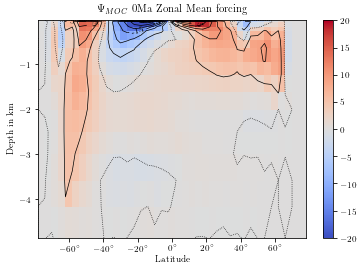

In [3]:
fig, ax = plt.subplots()

#MOC[0][MOC[0] == 0] = np.nan
result = ax.contour(yt,zt/1000,MOC[0]/1e6,13, colors='k',linewidths=0.7)
cb = ax.pcolormesh(yt,zt/1000,MOC[0]/1e6, cmap='coolwarm', vmin=-20,vmax=20)
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter(r"$%i^{\circ}$"))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("$%i$"))
ax.clabel(result,result.levels[::2], fontsize=9, inline=1,fmt="%i")
# Override the linestyles based on the levels.
for line, lvl in zip(result.collections, result.levels):
    if lvl < 0:
        line.set_linestyle('--')
    if lvl == 0:
        line.set_linestyle(':')
    else:
        # Optional; this is the default.
        line.set_linestyle('-')
plt.colorbar(cb)
plt.title(r'$\Psi_{MOC}$ 0Ma Zonal Mean forcing')
plt.xlabel('Latitude')
plt.ylabel('Depth in km')
#plt.savefig('../figures/overturning_0ma_old.png', dpi=400)
plt.show()

In [5]:

def newColor(start, end, N=50):
    vals = np.ones((N, 4))
    vals[:,0] = np.linspace(start[0],end[0],N)
    vals[:,1] = np.linspace(start[1],end[1],N)
    vals[:,2] = np.linspace(start[2],end[2],N)
    return vals

#first
c1 = newColor((1,1,1), (0.5,0,1))
c2 = newColor((0.5,0,1), (0,0,0.75))

#second
c3 = newColor((0,1,1), (0,0.5,1))
c4 = newColor((0,0.5,1), (0,0.25,0.5))

#third
c5 = newColor((0.5,1,0.75), (0.25, 0.5,0))
c6 = newColor((0.25, 0.5,0), (1,1,0))

#fourth
c7 = newColor((1,0.5,0), (0.75, 0,0))
c8 = newColor((0.75, 0,0), (1,0.75,0.25))

#fifth
c9 = newColor((0.5,0,0), (1, 0.75,0.75))
c10 = newColor((1, 0.75,0.75), (0.75,0,0.25))


print(c1.shape)
print(c2.shape)
# combine them and build a new colormap
colors = np.vstack((c1,c2,c3,c4,c5,c6,c7,c8,c9,c10))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors, N=100)


(50, 4)
(50, 4)


[]

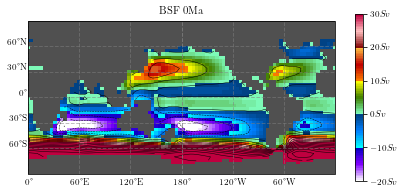

In [4]:
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.ylabels_right = False

bsf, xtf = cutil.add_cyclic_point(BSF[0], coord=xt)
temp, _ = cutil.add_cyclic_point(TEMP[0], coord=xt)
temp = np.flip(temp,axis=0)
ax.imshow(np.tile(np.array([[[80, 80, 80]]], 
          dtype=np.uint8), [2, 2, 1]),
      origin='upper',
      transform=ccrs.PlateCarree(),
      extent=[-180, 180, -180, 180])

result = plt.contour(xtf,yt,bsf / 1e6, colors='black', vmin=-15, vmax=15, levels=20, transform=ccrs.PlateCarree(),linewidths = 0.5)

cmsa = plt.imshow(np.flip(bsf,axis=0)/1e6, cmap=mymap, vmin=-20, vmax=30, origin='upper',extent=[-180, 180, -80, 80], transform=ccrs.PlateCarree(),interpolation='none')
plt.colorbar(cmsa,format=r"$%i Sv$",fraction=0.025, pad=0.06)
plt.title(r"BSF 0Ma")
plt.savefig('../figures/BSF_0ma_old.png',dpi=400)
plt.plot()



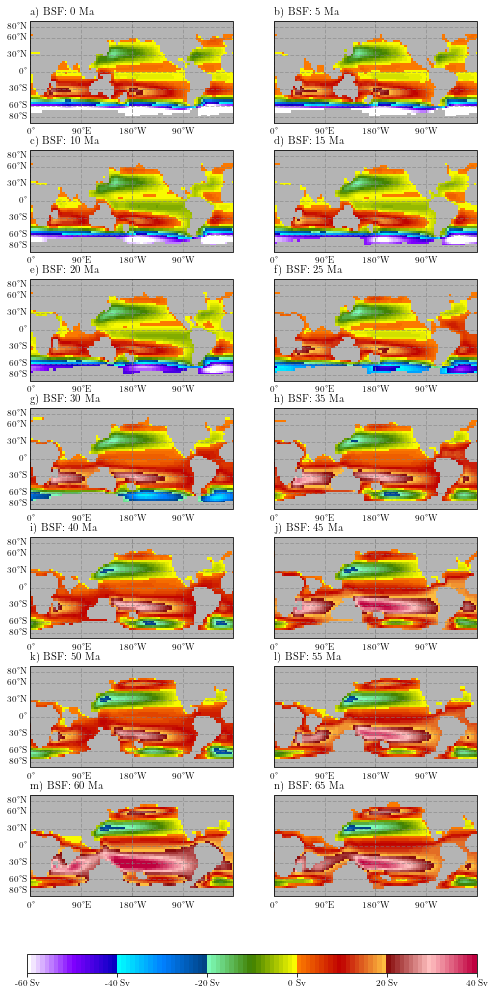

In [5]:
#fig = plt.figure()

pdf = matplotlib.backends.backend_pdf.PdfPages("../figures/BSF_full.pdf")

fig, axes = plt.subplots( 7,2, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),figsize=(8, 17))

#all : 8,17
#only 4(2,2): 8, 4.6
#only 10(5,2): 8,12

time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65]
letter = list(string.ascii_lowercase)

i = 0
for row in axes:
    for col in row:
        if i > 14:
            continue
        gl = col.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
        if i % 2 == 0:
            gl.xlabels_top = False
            gl.ylabels_right = False
        else:
            gl.xlabels_top = False
            gl.ylabels_right = False
            gl.ylabels_left = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylocator = mticker.FixedLocator([-80, -60, -30, 0, 30, 60, 80])
        gl.xlocator = mticker.FixedLocator([-180,-90, 0,90, 180])
        
        
        bsf, xtf = cutil.add_cyclic_point(BSF[i], coord=xt)
        col.imshow(np.tile(np.array([[[180, 180, 180]]], 
          dtype=np.uint8), [2, 2, 1]),
      origin='upper',
      transform=ccrs.PlateCarree(),
      extent=[-180, 180, -180, 180])
        tom = col.imshow(np.flip(-bsf,axis=0)/1e6, cmap=mymap, vmin=-60, vmax=40, origin='upper',extent=[-180, 180, -80, 80], transform=ccrs.PlateCarree(), interpolation='none')
        col.set_title("%s) BSF: %i Ma" % (letter[i],time[i]), loc='left')
        i = i+1
#plt.tight_layout()
fig.subplots_adjust(bottom=0.16) 
cbar_ax = fig.add_axes([0.12, 0.10, 0.78, 0.015])
fig.colorbar(tom, cax=cbar_ax,format='%i Sv', fraction=0.025, pad=0.08, orientation='horizontal')

pdf.savefig(fig)
pdf.close()

In [13]:
radearth = 6371000
torad = np.pi/180.0

currentrad = radearth

heights = np.flip(dzt)



volume = (1/3) * np.array(area_u[0]) * currentrad

# Now we have all the
area = np.zeros((16,40,))
volumes = np.zeros((16,40,))

for h, d in enumerate(heights):
    for i, dy in enumerate(np.array(yt) + 90):
        area[h,i] = currentrad**2 * 4 * torad * (np.cos((dy-2)*torad) - np.cos((dy+2)*torad))
        currentrad = currentrad - d

for i, dy in enumerate(np.array(yt) + 90):
    area[15,i] = currentrad**2 * 4 * torad * (np.cos((dy-2)*torad) - np.cos((dy+2)*torad))

currentrad = radearth
for h, d in enumerate(heights):
    volumes[h] = (1/3)*currentrad*area[h]
    currentrad = currentrad - d

volumes[15] = (1/3)*currentrad*area[15]


#gridvolumes = np.flip(np.array([np.transpose(np.repeat([volumes[i]-volumes[i+1]],90,axis=0)) for i in range(15)]),axis=0)
gridvolumes = np.transpose(np.repeat([np.array([volumes[i]-volumes[i+1] for i in range(15)])],90,axis=0),(1,2,0))


In [14]:
u=np.array(u)
depth = np.zeros((40,90))
for yi, y in enumerate(np.transpose(~np.isnan(u[0,:]),axes=(1,2,0))):
    for xi, x in enumerate(y):
        if len(x[x]) == 0:    
            depth[yi,xi] = np.nan
        else:
            depth[yi,xi] = np.sum(np.transpose(gridvolumes,axes=(1,2,0))[yi,xi,-len(x[x])::])


0.05441074153158595
4.101654846212442e-05


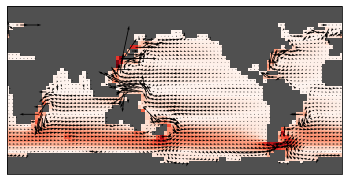

In [125]:
fig = plt.figure()
u=np.array(u)
v=np.array(v)

ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.imshow(np.tile(np.array([[[80, 80, 80]]], 
          dtype=np.uint8), [2, 2, 1]),
      origin='upper',
      transform=ccrs.PlateCarree(),
      extent=[-180, 180, -180, 180])
ufield = np.nansum(u[0,:]*gridvolumes,axis = 0)/depth
vfield = np.nansum(v[0,:]*gridvolumes, axis = 0)/depth
ufield[np.isnan(ufield)] = 0.
vfield[np.isnan(vfield)] = 0.

ufield, xtf = cutil.add_cyclic_point(ufield, coord=xt)
vfield, _ = cutil.add_cyclic_point(vfield, coord=xt)

velofield = np.sqrt(ufield**2 + vfield**2)
velofield[velofield == 0] = np.nan

tonan = (ufield == 0.) & (vfield == 0.)

ufield[tonan] = np.nan
vfield[tonan] = np.nan

zonalmean = np.nanmean(velofield, axis = 1)
print(np.nanmax(velofield))
print(np.nanmin(velofield))
ax.imshow(np.flip(velofield,axis = 0), cmap='Reds', origin='upper', extent=[-180, 180, -80, 80], transform=ccrs.PlateCarree(),interpolation='none')
#plt.plot(zonalmean)

ufield = ufield/zonalmean.reshape(-1,1)
vfield = vfield/zonalmean.reshape(-1,1)


plt.quiver(xtf,yt,ufield,vfield, transform=ccrs.PlateCarree())

In [62]:
u=np.array(u)
v=np.array(v)
pdf = matplotlib.backends.backend_pdf.PdfPages("../figures/flowfield_full.pdf")
fig, axes = plt.subplots( 7,2, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),figsize=(8, 17))

#all : 8,17
#only 4(2,2): 8, 4.6
#only 10(5,2): 8,12

time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65]
letter = list(string.ascii_lowercase)
i=0
for row in axes:
    for col in row:
        if i > 13:
            continue
        print(i)
        depth = np.zeros((40,90))
        for yi, y in enumerate(np.transpose(~np.isnan(u[i,:]),axes=(1,2,0))):
            for xi, x in enumerate(y):
                if len(x[x]) == 0:    
                    depth[yi,xi] = np.nan
                else:
                    depth[yi,xi] = np.sum(np.transpose(gridvolumes,axes=(1,2,0))[yi,xi,-len(x[x])::])

        gl = col.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
        if i % 2 == 0:
            gl.xlabels_top = False
            gl.ylabels_right = False
        else:
            gl.xlabels_top = False
            gl.ylabels_right = False
            gl.ylabels_left = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylocator = mticker.FixedLocator([-80, -60, -30, 0, 30, 60, 80])
        gl.xlocator = mticker.FixedLocator([-180,-90, 0,90, 180])

        col.imshow(np.tile(np.array([[[80, 80, 80]]], 
                dtype=np.uint8), [2, 2, 1]),
            origin='upper',
            transform=ccrs.PlateCarree(),
            extent=[-180, 180, -180, 180])
        ufield = np.nansum(u[i,:]*gridvolumes,axis = 0)/depth
        vfield = np.nansum(v[i,:]*gridvolumes, axis = 0)/depth
        ufield[np.isnan(ufield)] = 0.
        vfield[np.isnan(vfield)] = 0.

        ufield, xtf = cutil.add_cyclic_point(ufield, coord=xt)
        vfield, _ = cutil.add_cyclic_point(vfield, coord=xt)

        velofield = np.sqrt(ufield**2 + vfield**2)
        velofield[velofield == 0] = np.nan

        tonan = (ufield == 0.) & (vfield == 0.)

        ufield[tonan] = np.nan
        vfield[tonan] = np.nan

        zonalmean = np.nanmean(velofield, axis = 1)

        tom = col.imshow(np.flip(velofield,axis = 0), cmap='Reds', origin='upper', extent=[-180, 180, -80, 80], transform=ccrs.PlateCarree(),interpolation='none')
        #plt.plot(zonalmean)

        ufield = ufield/zonalmean.reshape(-1,1)
        vfield = vfield/zonalmean.reshape(-1,1)


        col.quiver(xtf,yt,ufield,vfield, transform=ccrs.PlateCarree())
        col.set_title("%s) Flowfield: %i Ma" % (letter[i],time[i]), loc='left')
        i = i+1
fig.subplots_adjust(bottom=0.16) 
cbar_ax = fig.add_axes([0.12, 0.10, 0.78, 0.015])
fig.colorbar(tom, cax=cbar_ax,format='%i Sv', fraction=0.025, pad=0.08, orientation='horizontal')
pdf.savefig(fig)
pdf.close()

0


NameError: name 'gridvolumes' is not defined

Plot the MOC


In [4]:

def newColor(start, end, N=50):
    vals = np.ones((N, 4))
    vals[:,0] = np.linspace(start[0],end[0],N)
    vals[:,1] = np.linspace(start[1],end[1],N)
    vals[:,2] = np.linspace(start[2],end[2],N)
    return vals

#first
c1 = newColor((1,1,1), (0.5,0,1))
c2 = newColor((0.5,0,1), (0,0,0.75))

#second
c3 = newColor((0,1,1), (0,0.5,1))
c4 = newColor((0,0.5,1), (0,0.25,0.5))

#third
c5 = newColor((0.5,1,0.75), (0.25, 0.5,0))
c6 = newColor((0.25, 0.5,0), (1,1,0))



#fifth
c9 = newColor((0.5,0,0), (1, 0.75,0.75))
c10 = newColor((1, 0.75,0.75), (0.75,0,0.25))


#sixth
c11 = newColor((1,1,1), (1, 0.25,0.75))
c12 = newColor((1, 0.25,0.75), (1,0.5,1))

#fourth
c7 = newColor((1,0.5,0), (0.75, 0,0))
c8 = newColor((0.75, 0,0), (1,1,1))

print(c1.shape)
print(c2.shape)
# combine them and build a new colormap
colors = np.vstack((c5,c6,c1,c2,c3,c4,c9,c10,c7,c8,c11,c12))
mocmap = mcolors.LinearSegmentedColormap.from_list('mocmap', colors, N=200)

(50, 4)
(50, 4)


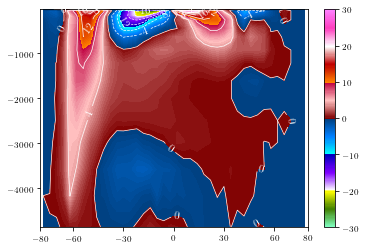

In [11]:


fig, ax = plt.subplots()
cs = ax.contour(yt,zt,MOC[0]/1e6,np.arange(-16,16.1,4),colors='w',linewidths=0.7,vmin=-15,vmax=15)
tom = ax.contourf(yt,zt,MOC[0]/1e6,np.arange(-30,30.1,0.1),cmap=mocmap,linewidths=0.7)

ax.clabel(cs, cs.levels, inline=True,fmt="%i", fontsize=11)

#tom = plt.contourf(yt,zt,-MOC[0]/1e6,np.arange(-30,30.1,0.1),cmap=mocmap,linewidths=0.7)
plt.xticks([-80,-60,-30,0,30,60,80])
#ax.pcolormesh(yt,zt,MOC[0]/1e6,cmap=mocmap,vmin=-25,vmax=25)
plt.colorbar(tom,ticks=[-30,-20,-10, 0, 10,20,30])

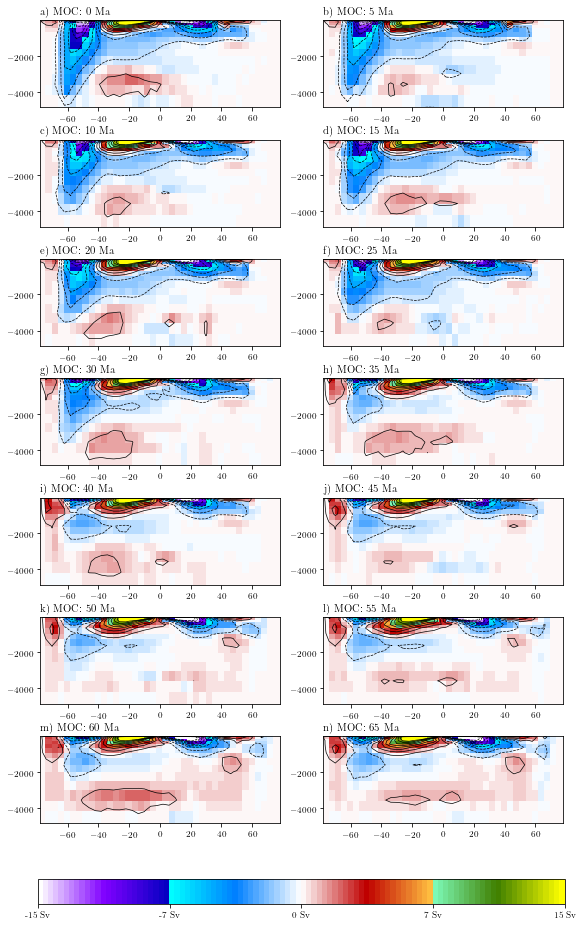

In [25]:
pdf = matplotlib.backends.backend_pdf.PdfPages("../figures/MOC_full.pdf")
fig, axes = plt.subplots( 7,2, figsize=(8,14))

#all : 8,17
#only 4(2,2): 8, 4.6
#only 10(5,2): 8,14
time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65]
letter = list(string.ascii_lowercase)
i=0


for row in axes:
    for col in row:
        if i > 13:
            continue
        col.contour(yt,zt,-MOC[i]/1e6,np.arange(-15,16,2),colors='k',linewidths=0.7,vmin=-15,vmax=15)
        tom = col.pcolormesh(yt,zt, -MOC[i]/1e6,cmap=mocmap,vmin=-15,vmax=15)
        col.set_title("%s) MOC: %i Ma" % (letter[i],time[i]), loc='left')
        i = i + 1
plt.tight_layout()
fig.subplots_adjust(bottom=0.18) 
cbar_ax = fig.add_axes([0.07, 0.10, 0.915, 0.025])
fig.colorbar(tom, cax=cbar_ax,format='%i Sv', fraction=0.025, pad=0.08, orientation='horizontal',ticks=[-15,-7.5, 0,7.5, 15])

pdf.savefig(fig)

pdf.close()

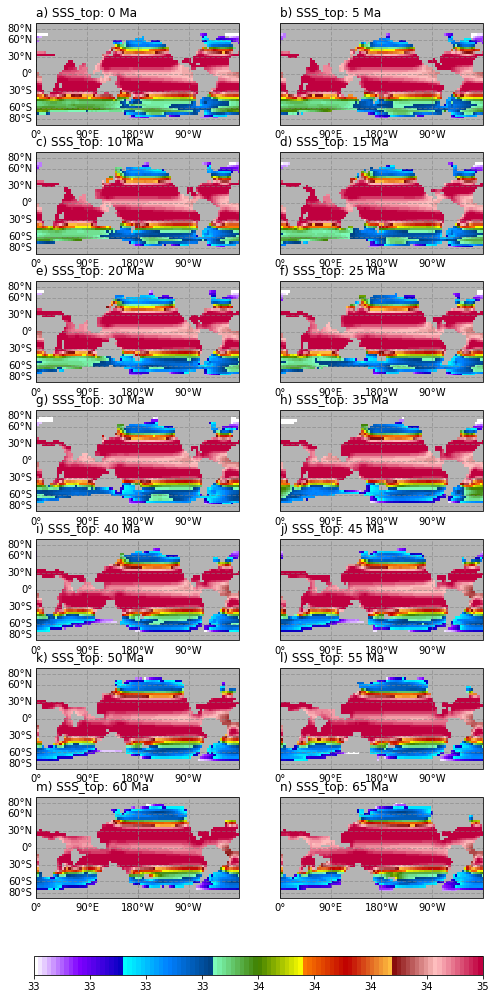

In [7]:
#fig = plt.figure()

pdf = matplotlib.backends.backend_pdf.PdfPages("../figures/SSS_full_weird.pdf")

fig, axes = plt.subplots( 7,2, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),figsize=(8, 17))

#all : 8,17
#only 4(2,2): 8, 4.6
#only 10(5,2): 8,12

time = [0,5,10,15,20,25,30,35,40,45,50,55,60,65]
letter = list(string.ascii_lowercase)

i = 0
for row in axes:
    for col in row:
        if i > 14:
            continue
        gl = col.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
        if i % 2 == 0:
            gl.xlabels_top = False
            gl.ylabels_right = False
        else:
            gl.xlabels_top = False
            gl.ylabels_right = False
            gl.ylabels_left = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylocator = mticker.FixedLocator([-80, -60, -30, 0, 30, 60, 80])
        gl.xlocator = mticker.FixedLocator([-180,-90, 0,90, 180])
        
        
        sss, xtf = cutil.add_cyclic_point(SSS[i], coord=xt)
        col.imshow(np.tile(np.array([[[180, 180, 180]]], 
          dtype=np.uint8), [2, 2, 1]),
      origin='upper',
      transform=ccrs.PlateCarree(),
      extent=[-180, 180, -180, 180])
        tom = col.imshow(np.flip(sss,axis=0), cmap=mymap, vmin=33, vmax=35, origin='upper',extent=[-180, 180, -80, 80], transform=ccrs.PlateCarree(), interpolation='none')
        col.set_title("%s) SSS: %i Ma" % (letter[i],time[i]), loc='left')
        i = i+1
#plt.tight_layout()
fig.subplots_adjust(bottom=0.16) 
cbar_ax = fig.add_axes([0.12, 0.10, 0.78, 0.015])
fig.colorbar(tom, cax=cbar_ax,format='%i', fraction=0.025, pad=0.08, orientation='horizontal')

pdf.savefig(fig)
pdf.close()